# LangChain과 ChatGPT를 사용한 PostgreSQL RAG

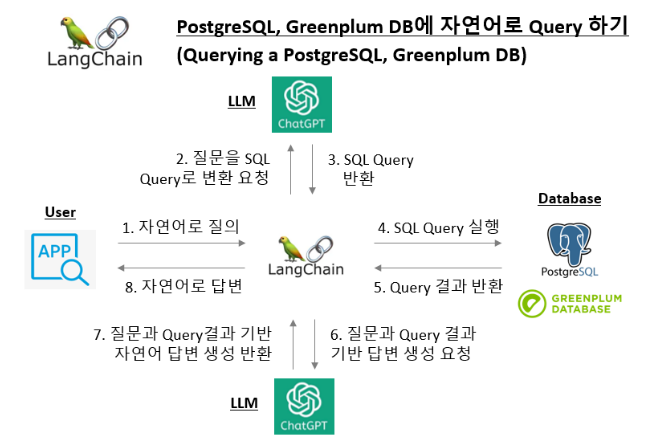

(1) 사용자가 애플리케이션에서 자연어로 질의

(2) LangChain이 LLM 모델에 사용자 질문을 SQL Query로 변환 요청

(3) LLM 모델이 DB Schema 정보에 기반해 사용자 질문에 대한 SQL Query를 생성해서 반환

(4) LangChain이 PostgreSQL, Greenplum DB에 SQL Query 실행 요청

(5) PostgreSQL, Greenplum DB에서 SQL Query 실행하여 결과 반환

(6) LangChain이 사용자 질문과 SQL Query, Query 결과를 기반으로 LLM 모델에 답변 생성 요청

(7) LLM 모델이 사용자 질문과 Query 결과를 기반으로 생성한 자연어 답변 반환

(8) LangChain이 애플리케이션의 사용자 UI에 LLM 모델이 생성한 자연어 답변 반환


### (0) 사전 준비

In [ ]:
! pip install -q openai langchain psycopg2

In [ ]:
########## OpenAI API Key 설정 ##########
import os
# setup OpenAI API Key with yours
os.environ["OPENAI_API_KEY"]="sk-xxxx..." # set with yours



########## PostgreSQL DB 연결 ##########
# Connect to the PostgreSQL DB
from langchain.utilities import SQLDatabase

# set with yours
username='postgres'
password='changeme'
host='localhost'
port='5432'
database='postgres'

pg_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

db = SQLDatabase.from_uri(pg_uri)



########## Query를 위한 Helper Function 정의 ##########
# Helper functions
def get_schema(_):
    return db.get_table_info()

def run_query(query):
    return db.run(query)

### (1) 자연어로 질의

In [ ]:
# Prompt for generating a SQL query
from langchain.prompts import ChatPromptTemplate

template_query = """
Based on the table schema below, \
Write a PostgreSQL query that answer the user's question:
{schema}

Question: {question}
SQL Query:"""

prompt = ChatPromptTemplate.from_template(template_query)

### (2) 질문을 SQL Query로 변환 요청

In [ ]:
# Chaining prompt, LLM model, and Output Parser
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

model = ChatOpenAI(temperature=0, model_name='gpt-4')

sql_response = (
    RunnablePassthrough.assign(schema=get_schema)
    | prompt
    | model.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)


# (참고)
# : LLM에는 ChatGPT-4 모델을 사용하고, temperature=0 으로 해서 사실에 기반해서 일관성 있고 보수적인 답변을 생성하도록 설정

### (3) 질문에 대한 SQL Query를 생성해서 반환

In [ ]:
sql_response.invoke({"question": "What is the average of sepal length for Iris-setosa?"})
# "SELECT AVG(sepal_length) \nFROM iris \nWHERE class_name = 'Iris-setosa';"


# (참고)
# : 이때, SQL문 생성하는 LLM 모델은 Code-Llama 등의 코딩 특화 모델을 사용하면 더욱 좋은 성능이 기대됨

### (4) PostgreSQL, Greenplum DB에 SQL Query 실행 요청

In [ ]:
# Prompt for generating the final answer by running a SQL query on DB
template_response = """
Based on the table schema below, question, sql query, and sql response, \
write a natural language response:
{schema}

Question: {question}
SQL Query: {query}
SQL Response: {response}"""

prompt_response = ChatPromptTemplate.from_template(template_response)


# (참고)
# : "DB 테이블 정보 ("schema"), 사용자 질문 ("question"), SQL Query ("query"), SQL Query 결과 ("response") 가 주어졌을 때
#   자연어(natural language)로 답변을 생성하라"고 프롬프트 지시문을 구성함

### (5) Greenplum DB에서 SQL Query 실행하여 결과 반환

In [ ]:
full_chain = (
    RunnablePassthrough.assign(query=sql_response)
    | RunnablePassthrough.assign(
        schema=get_schema,
        response=lambda x: db.run(x["query"]),
    )
    | prompt_response
    | model
    | StrOutputParser()
)


# (참고)
# : '|' 를 사용해서 앞에서 정의한 SQL Query 생성하는 chain과 Query를 실행한 결과를 받아서
#   자연어로 답변을 생성하는 chain을 모두 엮어서 Chaining 하였습니다.

### (6) 사용자 질문과 SQL Query, Query 결과를 기반으로 LLM 모델에 답변 생성 요청

In [ ]:
full_chain = (
    RunnablePassthrough.assign(query=sql_response)
    | RunnablePassthrough.assign(
        schema=get_schema,
        response=lambda x: db.run(x["query"]),
    )
    | prompt_response
    | model
    | StrOutputParser()
)


# (참고)
# : '|' 를 사용해서 앞에서 정의한 SQL Query 생성하는 chain과 Query를 실행한 결과를 받아서
#   자연어로 답변을 생성하는 chain을 모두 엮어서 Chaining 하였습니다.

In [ ]:
## User Query: What is the average of sepal length for Iris-setosa?


sql_response.invoke({"question": "What is the average of sepal length for Iris-setosa?"})
# "SELECT AVG(sepal_length) \nFROM iris \nWHERE class_name = 'Iris-setosa';"

full_chain.invoke({"question": "What is the average of sepal length for Iris-setosa?"})
# 'The average sepal length for Iris-setosa is approximately 4.86.'

위의 예는 매우 간단한 질문이어서 하나의 테이블 내에서 Join 없이도 모두 정확하게 Querying 이 되었는데요, 그래도 mission critical한 업무에서는 사용에 유의할 필요가 있습니다.

왜냐하면 실무에서 사용하는 SQL Query 문의 경우 여러개의 테이블을 Join 해야 될 수도 있고, Where 조건절에 Business Logic이 복잡하게 반영되어야 할 경우도 있고, 테이블 이름/설명이나 변수명/설명이 LLM 모델이 사용자의 질의와 매핑해서 사용하기에 부적절한 경우도 있을 수 있어서 SQL Query가 부정확할 수 있기 때문입니다.

따라서 반드시 사용자 질의에 대한 SQL Query 문을 같이 확인해보는 절차가 필요합니다.


+ 그리고 SQL Query Generator 를 잘하는 LLM 모델, 자사 회사 내 SQL Query 문으로 Fine-tuning한 LLM 모델에 대한 시도도 의미있어 보임!
